# Transformers Architecture

**Importing Libraries**

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

**Create a simple Transformer model**

In [4]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

**Define the Encoder**

In [5]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

**Define the Encoder Layer**

In [6]:
# Define the Encoder Layer
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

**Define the Decoder**

In [7]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

**Define the Decoder Layer**

In [8]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

**Define MultiHeadAttention**

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

**Define the point wise feed forward network**

In [9]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

**Define positional encoding**

In [10]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

**Generate sample data**

In [11]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048,
    input_vocab_size=8500, target_vocab_size=8000,
    pe_input=10000, pe_target=6000)

# Sample input
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

# Sample target
temp_target = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

# Sample training mask
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(temp_input, temp_target)

# Forward pass
predictions, attention_weights = sample_transformer(temp_input, temp_target, training=False,
                                                    enc_padding_mask=enc_padding_mask,
                                                    look_ahead_mask=look_ahead_mask,
                                                    dec_padding_mask=dec_padding_mask)

**Plotting attention weights**

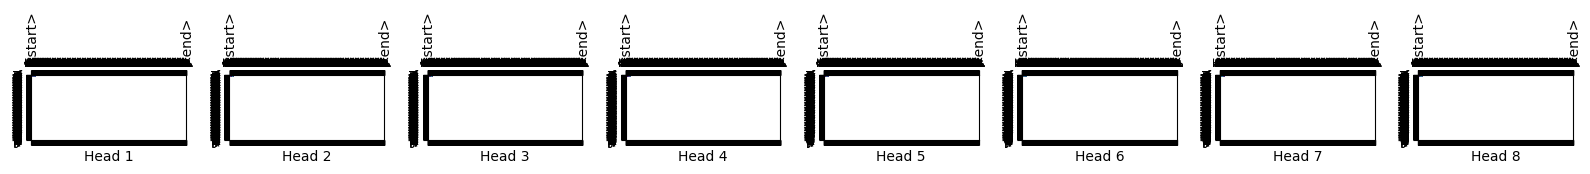

In [12]:
def plot_attention_weights(attention, sentence, result, layer):
    fig = plt.figure(figsize=(16, 8))

    sentence = " ".join([str(x) for x in sentence])
    result = " ".join([str(x) for x in result])

    attention = attention[layer]

    num_heads = attention.shape[1]
    num_columns = min(num_heads, 8)
    num_rows = (num_heads - 1) // num_columns + 1

    for head in range(num_heads):
        ax = fig.add_subplot(num_rows, num_columns, head + 1)

        # plot the attention weights
        ax.matshow(attention[0][head][:-1, :], cmap='viridis')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(sentence) + 2))
        ax.set_yticks(range(len(result)))

        ax.set_ylim(len(result) - 1.5, -0.5)

        ax.set_xticklabels(['<start>'] + [w for w in sentence] + ['<end>'],
                           fontdict=fontdict, rotation=90)

        ax.set_yticklabels([w for w in result if w != '<end>'],
                           fontdict=fontdict)

        ax.set_xlabel('Head {}'.format(head + 1))

    plt.tight_layout()
    plt.show()

plot_attention_weights(attention_weights, temp_input[0], temp_target[0], 'decoder_layer2_block2')